In [1]:
import geopandas as gpd
import pandas as pd
pd.set_option('display.max_columns', 50)
from shapely.geometry import Point, LineString
from geopandas import GeoDataFrame
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
import seaborn as sns

## 1. Creating classification of investor from real estate tax transfer

In [2]:
# import data
rtt = pd.read_csv("/Users/darebrawley/Google Drive/CourseWork/2019-2020/00_thesis/00_data/RAW/philadelphia/realestate_tax_transfers/RTT_SUMMARY.csv")

/Users/darebrawley/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (26,34,39) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
rtt.head()

adjusted_state_tax_amount  objectid        document_type display_date  \
0                        NaN   7740896         SATISFACTION   2000-02-01   
1                        NaN   7740897  RELEASE OF MORTGAGE   2000-02-01   
2                        NaN   7740898         SATISFACTION   2000-02-01   
3                        NaN   7740899  RELEASE OF MORTGAGE   2000-02-01   
4                        NaN   7740900         SATISFACTION   2000-02-01   

  street_address  zip_code  ward  \
0            NaN       NaN   NaN   
1            NaN       NaN   NaN   
2            NaN       NaN   NaN   
3            NaN       NaN   NaN   
4            NaN       NaN   NaN   

                                            grantors  \
0            KEYSTONE FINANCIAL MORTGAGE CORPORATION   
1  ADVANTA MORTGAGE CORP USA; AMERICAN BENEFIT MO...   
2  NATIONSCREDIT HOME EQUITY SERVICES CORPO; TREV...   
3                       AMERICAN BUSINESS CREDIT INC   
4  AMERICAN MORTGAGE REDUCTION INC; IMC MORTGAGE ...   

                             grantees  cash_consideration  \
0       BAEHR ARTHUR L; BAEHR DEBRA A                 NaN   
1  DELEO STACEY A; DELEO THOMAS M III                 NaN   
2        IRIS ROSA; SHANNON WILLIAM G                 NaN   
3  AMATO CHRISTINE M; AMATO MICHAEL R                 NaN   
4       WILLIAMS FRANK; WILLIAMS INGE                 NaN   

   other_consideration  total_consideration  assessed_value  \
0                  NaN                  NaN             NaN   
1                  NaN                  NaN             NaN   
2                  NaN                  NaN             NaN   
3                  NaN                  NaN             NaN   
4                  NaN                  NaN             NaN   

   common_level_ratio  fair_market_value  state_tax_amount  state_tax_percent  \
0                 NaN                NaN               NaN                NaN   
1                 NaN                NaN               NaN                NaN   
2                 NaN                NaN               NaN                NaN   
3                 NaN                NaN               NaN                NaN   
4                 NaN                NaN               NaN                NaN   

   local_tax_amount  local_tax_percent  adjusted_cash_consideration  \
0               NaN                NaN                          NaN   
1               NaN                NaN                          NaN   
2               NaN                NaN                          NaN   
3               NaN                NaN                          NaN   
4               NaN                NaN                          NaN   

   adjusted_other_consideration  adjusted_total_consideration  \
0                           NaN                           NaN   
1                           NaN                           NaN   
2                           NaN                           NaN   
3                           NaN                           NaN   
4                           NaN                           NaN   

   adjusted_assessed_value  adjusted_fair_market_value  document_id  \
0                      NaN                         NaN     50028274   
1                      NaN                         NaN     50028322   
2                      NaN                         NaN     50028541   
3                      NaN                         NaN     50028712   
4                      NaN                         NaN     50028942   

   adjusted_local_tax_amount receipt_num receipt_date recording_date  \
0                        NaN         NaN          NaN     2000-02-01   
1                        NaN         NaN          NaN     2000-02-01   
2                        NaN         NaN          NaN     2000-02-01   
3                        NaN         NaN          NaN     2000-02-01   
4                        NaN         NaN          NaN     2000-02-01   

  document_date condo_name unit_num  address_low address_low_suffix  \
0         

In [4]:
# selecting just deeds
deeds = rtt.loc[rtt['document_type'] == "DEED"]

# adding a year column from the document date
deeds["sort_year"] = deeds['display_date'].astype(str).str[:4]


/Users/darebrawley/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [5]:
# points form xy
deeds_points = [Point(xy) for xy in zip(deeds.lng, deeds.lat)]
deedsgeo = GeoDataFrame(deeds, geometry=deeds_points)

In [6]:
# selecting only deeds with non zero state taxes
deeds_above0 = deedsgeo.loc[deedsgeo["state_tax_amount"] > 0]

# and that also have an address field
deeds_above0_has_address= deeds_above0.loc[deeds_above0["address_low"]>0]

In [7]:
# setting the projection for the lat lon coordinates 
deeds_above0_has_address.crs = {'init' :'epsg:4326'}

In [8]:
# reprojecting to: EPSG:2272: NAD83 / Pennsylvania South (ftUS)
deeds_above0_has_address = deeds_above0_has_address.to_crs({'init':'epsg:2272'})

In [9]:
# selecting investors by grantee name
invest_class = deeds_above0_has_address["grantees"].str.contains('LLC|LP|CORP|CORPORATION', regex=True)


In [10]:
# converting investors series to dataframe
invest_class = invest_class.to_frame()

In [11]:
# merging with deeds
deeds_inv_class = deeds_above0_has_address.merge(invest_class, left_index=True, right_index=True)

In [12]:
# check to see whether there are any grantee fields with na values
nan_grantees = deeds_inv_class.loc[deeds_inv_class['grantees_x'].isna()]
nan_grantees.shape

(45, 51)

In [13]:
# drop these na grantee sales
deeds_inv_class_grantee = deeds_inv_class.loc[deeds_inv_class['grantees_x'].isna() == False]

In [14]:
# drop all deeds before 1999
deeds_inv_class_grantee['sort_year'] = pd.to_numeric(deeds_inv_class_grantee['sort_year'])
deeds_inv_class_grantee = deeds_inv_class_grantee.loc[deeds_inv_class_grantee['sort_year'] > 1998]

/Users/darebrawley/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [15]:
deeds_inv_class_grantee.head()

adjusted_state_tax_amount  objectid document_type display_date  \
2312                      589.0   7744699          DEED   2004-04-02   
2320                      920.0   7744935          DEED   2000-05-25   
2328                     1230.0   7744943          DEED   2004-05-28   
2330                      930.0   7744945          DEED   2004-05-28   
2335                      685.0   7744230          DEED   2004-05-05   

          street_address  zip_code  ward  \
2312     3083 MEMPHIS ST   19134.0  25.0   
2320      3631 AVALON ST   19114.0  66.0   
2328      3430 ALDINE ST   19136.0  64.0   
2330       5809 AKRON ST   19149.0  62.0   
2335  8237 ROSE PETAL DR   19111.0  56.0   

                                               grantors         grantees_x  \
2312              MCCAFFERTY MARIE E; TUCKER MARGARET T    IRWIN LEIGHANNE   
2320  TAYLOR COLERIDGE; TAYLOR ROBERT TR; TAYLOR RON...  FALLEN PAUL J III   
2328                        ROWLAND JAMES; ROWLAND JOAN      RUTA JOSEPH M   
2330                                         LAVIN BETH       DUFFIE JAMIE   
2335                  CHAMPION DEVELOPMWENT CORPORATION            NVR INC   

      cash_consideration  other_consideration  total_consideration  \
2312             58900.0                  NaN              58900.0   
2320             92000.0                  0.0              92000.0   
2328            123000.0                  NaN             123000.0   
2330             93000.0                  NaN              93000.0   
2335             68500.0                  NaN              68500.0   

      assessed_value  common_level_ratio  fair_market_value  state_tax_amount  \
2312             NaN                 NaN           30699.84             589.0   
2320             NaN                 NaN           63936.00             920.0   
2328             NaN                 NaN           43066.56            1230.0   
2330             NaN                 NaN           45344.64             930.0   
2335             NaN                 NaN          305913.60             685.0   

      state_tax_percent  local_tax_amount  local_tax_percent  \
2312              100.0            1767.0              100.0   
2320              100.0            2760.0              100.0   
2328              100.0            3690.0              100.0   
2330              100.0            2790.0              100.0   
2335              100.0            2055.0              100.0   

      adjusted_cash_consideration  adjusted_other_consideration  \
2312                      58900.0                           NaN   
2320                      92000.0                           NaN   
2328                     123000.0                           NaN   
2330                      93000.0                           NaN   
2335                      68500.0                           NaN   

      adjusted_total_consideration  adjusted_assessed_value  \
2312                       58900.0                      NaN   
2320                       92000.0                      NaN   
2328                      123000.0                      NaN   
2330                       93000.0                      NaN   
2335                       68500.0                      NaN   

      adjusted_fair_market_value  document_id    ...      receipt_num  \
2312                    30699.84     50942296    ...              NaN   
2320                    63936.00     50092387    ...              NaN   
2328                    43066.56     50942514    ...              NaN   
2330                    45344.64     50942516    ...              NaN   
2335                   305913.60     50941881    ...              NaN   

     receipt_date recording_date document_date condo_name unit_num  \
2312   2004-06-07     2004-06-07    2004-04-02        NaN      NaN   
2320   2000-06-07     2000-06-07    2000-05-25        NaN      NaN   
2328   2004-06-08     2004-06-08    2004-05-28        NaN      NaN   
2330   2004-06-08     2004-06-08    2004-05-2

In [16]:
# creating a count column to allow grouping and count 
# for investor and owner by year 
deeds_inv_class_grantee['inv'] = deeds_inv_class_grantee['grantees_y'].apply(lambda 
                                                                            x: 1 if x == True else 0)
deeds_inv_class_grantee['occ'] = deeds_inv_class_grantee['grantees_y'].apply(lambda 
                                                                           x: 1 if x == False else 0)

In [351]:
# saving out current categorized file
deeds_inv_class_grantee.to_csv("/Users/darebrawley/Google Drive/CourseWork/2019-2020/00_thesis/00_data/PROCESSED/realestate_tax_transfers/deeds_inv_class_grantee.csv")

### next steps on classification (12/7/2019)

- resolve land use data issue, select just those deeds that fall within residential land uses
- devise method for finding non LLC/Corp/LP buyers who purchased multiple properties within an X year span

## 2. for proposal: plotting by year




In [17]:
# grouping by year
grouped_year_sum = deeds_inv_class_grantee.groupby(['sort_year']).sum()
keepcolumns = ['inv','occ']
grouped_year_sum = grouped_year_sum[keepcolumns]
grouped_year_sum["total"] = grouped_year_sum['inv'] + grouped_year_sum['occ'] 
grouped_year_sum= grouped_year_sum.reset_index()
grouped_year_sum['inv_perc'] = grouped_year_sum['inv']/grouped_year_sum["total"]
grouped_year_sum['total_perc'] = grouped_year_sum['total']/grouped_year_sum['total']

In [19]:
grouped_year_sum

sort_year   inv    occ  total  inv_perc  total_perc
0        1999   188   4730   4918  0.038227         1.0
1        2000  1286  27017  28303  0.045437         1.0
2        2001  1639  27552  29191  0.056147         1.0
3        2002  1918  29123  31041  0.061789         1.0
4        2003  2602  30773  33375  0.077963         1.0
5        2004  3549  35113  38662  0.091796         1.0
6        2005  4667  37902  42569  0.109634         1.0
7        2006  4400  35193  39593  0.111131         1.0
8        2007  4592  29081  33673  0.136370         1.0
9        2008  3634  21314  24948  0.145663         1.0
10       2009  2975  18260  21235  0.140099         1.0
11       2010  3626  17841  21467  0.168910         1.0
12       2011  3695  15813  19508  0.189409         1.0
13       2012  4612  16839  21451  0.215002         1.0
14       2013  5382  18686  24068  0.223616         1.0
15       2014  5572  18510  24082  0.231376         1.0
16       2015  6977  20621  27598  0.252808         1.0
17       2016  8393  22854  31247  0.268602         1.0
18       2017  9299  23797  33096  0.280971         1.0
19       2018  9319  23602  32921  0.283072         1.0
20       2019  4991  11885  16876  0.295745         1.0

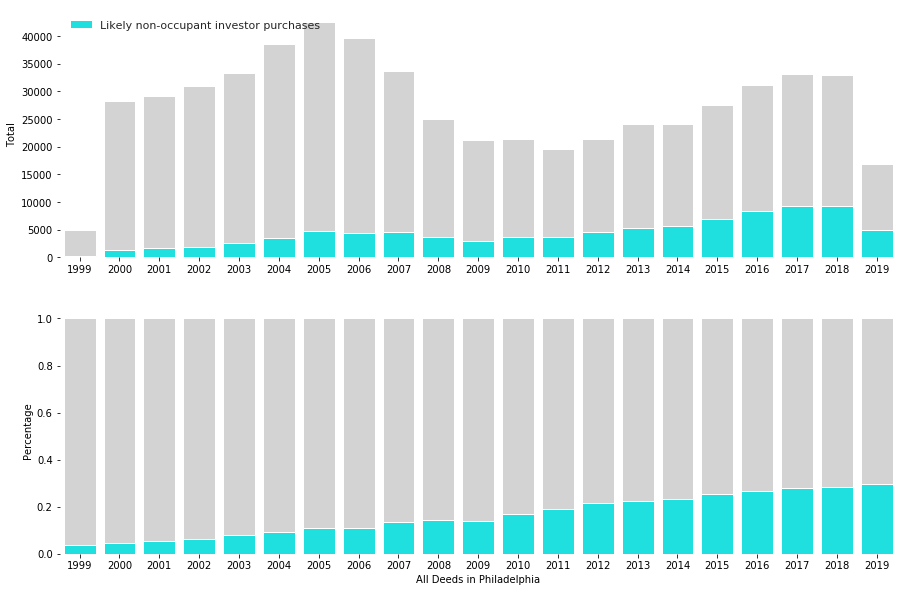

In [18]:
# barplot of deeds by year
f, (ax1,ax2) = plt.subplots(2,1,figsize=(15, 10))
# sns.load_data()
sns.set(style="white")
sns.barplot(ax=ax1, y='total',x='sort_year',data=grouped_year_sum, color='lightgrey')
# sns.barplot(y='occ',x='sort_year',data=grouped_year_sum, color='lightgrey')
sns.barplot(ax=ax1, y='inv',x='sort_year',data=grouped_year_sum, color='cyan', 
           label="Likely non-occupant investor purchases")
ax1.legend(loc="upper left", frameon=False)
ax1.set(xlabel=" ", ylabel="Total")

sns.barplot(ax=ax2, y='total_perc',x='sort_year',data=grouped_year_sum, color='lightgrey')
sns.barplot(ax=ax2, y='inv_perc',x='sort_year',data=grouped_year_sum, color='cyan', 
           label="Likely non-occupant investor purchases")
ax2.set(xlabel="All Deeds in Philadelphia", ylabel="Percentage")


sns.despine(left=True, bottom=True)



## 3. for proposal: preliminary maps by year

In [339]:
deeds18 = deeds_inv_class_grantee.loc[deeds_inv_class_grantee["sort_year"] == 2018]
deeds09 = deeds_inv_class_grantee.loc[deeds_inv_class_grantee["sort_year"] == 2009]
deeds00 = deeds_inv_class_grantee.loc[deeds_inv_class_grantee["sort_year"] == 2000]


In [349]:
true_false = LinearSegmentedColormap.from_list(
    'mycmap', [(0, 'grey'), (1, 'cyan')])
invisible = LinearSegmentedColormap.from_list(
    'mycmap', [(0, 'white'), (1, 'black')])
visible = LinearSegmentedColormap.from_list(
    'mycmap', [(0, 'black'), (1, 'white')])

In [289]:
# loading other base layers for plots
water = gpd.read_file("/Users/darebrawley/Google Drive/CourseWork/2019-2020/00_thesis/00_data/RAW/philadelphia/hyrdography/selected_water.geojson")
districts = gpd.read_file("/Users/darebrawley/Google Drive/CourseWork/2019-2020/00_thesis/00_data/RAW/philadelphia/planning_districts/Planning_Districts.geojson")
city = gpd.read_file("/Users/darebrawley/Google Drive/CourseWork/2019-2020/00_thesis/00_data/RAW/philadelphia/city_limits/City_Limits.geojson")
roads = gpd.read_file("/Users/darebrawley/Google Drive/CourseWork/2019-2020/00_thesis/00_data/RAW/philadelphia/tl_2017_42101_roads/tl_2017_42101_roads.shp")
njroads = gpd.read_file("/Users/darebrawley/Google Drive/CourseWork/2019-2020/00_thesis/00_data/RAW/philadelphia/tl_2015_34_prisecroads/nj_roads_select.geojson")
paroads = gpd.read_file("/Users/darebrawley/Google Drive/CourseWork/2019-2020/00_thesis/00_data/RAW/philadelphia/tl_2014_42_prisecroads/penn_roads_select.geojson")

In [290]:
# reprojecting to philadelphia crs
districts = districts.to_crs({'init':'epsg:2272'})
roads = roads.to_crs({'init':'epsg:2272'})
city = city.to_crs({'init':'epsg:2272'})
# njroads = njroads.to_crs({'init':'epsg:2272'})
# paroads = paroads.to_crs({'init':'epsg:2272'})


In [268]:
# selecting just major roads
roads_formap = roads.loc[roads["RTTYP"] != 'M']
# selecting just minor roads
roads_minorformap = roads.loc[roads["RTTYP"] == 'M']

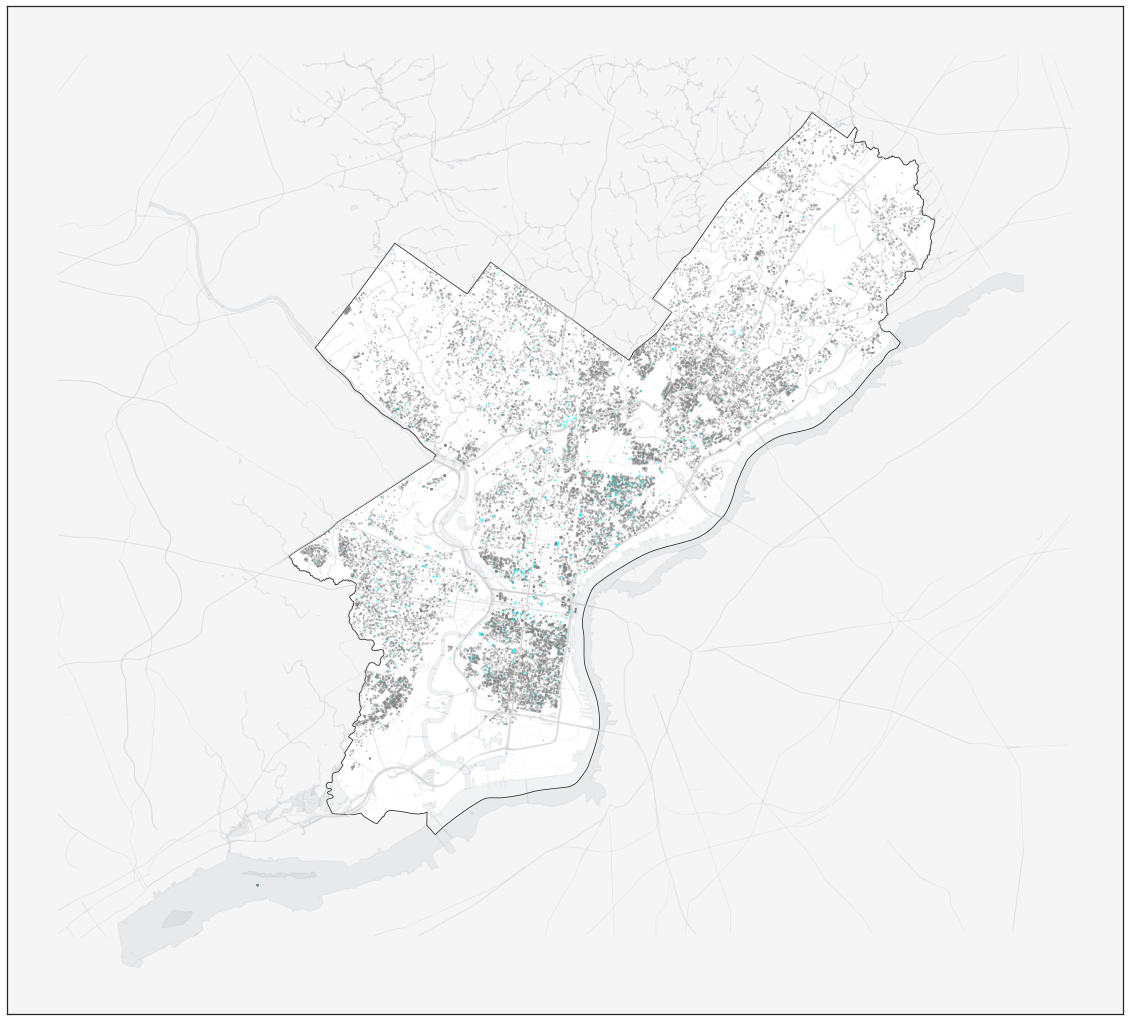

In [369]:
# 2000
fig, ax = plt.subplots(figsize=(20,20))
ax.set_aspect('equal')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

# below works to get rid of frame if there is no facecolor
# ax.axis('off')

# basemap
ax.set_facecolor("whitesmoke")
city.plot(ax=ax, color="white", edgecolor="k", linewidth=.75)
water.plot(ax=ax, color="lightslategray", edgecolor="lightslategray", alpha=.1)
paroads.plot(ax=ax, color="lightgrey", linewidth=.5, alpha=0.3)
njroads.plot(ax=ax, color="lightgrey",  linewidth=.5,  alpha=0.3)
roads_minorformap.plot(ax=ax, color="lightgrey", linewidth =0.25, alpha=0.3)
roads_formap.plot(ax=ax, color="lightgrey", alpha=.3)

# 2000 map
deeds00.plot(ax=ax, markersize=1, column = 'grantees_y', cmap=true_false, alpha=.3)

plt.savefig("/Users/darebrawley/Google Drive/CourseWork/2019-2020/00_thesis/01_analysis/02_outputs/2000_deeds.png") 
plt.show()

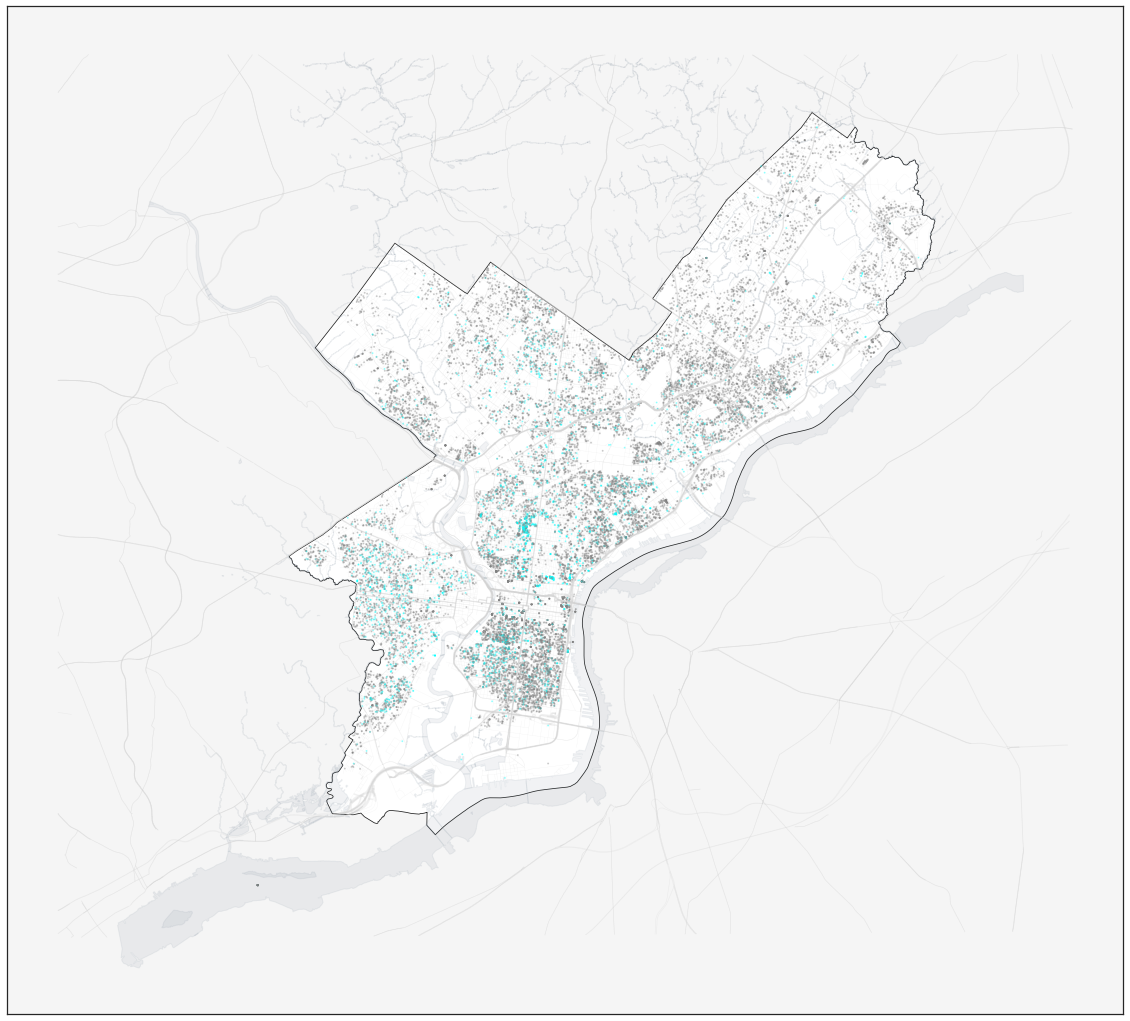

In [368]:
# 2009

# Frame etc
fig, ax = plt.subplots(figsize=(20,20))
ax.set_aspect('equal')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

# basemap
ax.set_facecolor("whitesmoke")
city.plot(ax=ax, color="white", edgecolor="k", linewidth=.75)
water.plot(ax=ax, color="lightslategray", edgecolor="lightslategray", alpha=.1)
paroads.plot(ax=ax, color="lightgrey", linewidth=.5, alpha=0.3)
njroads.plot(ax=ax, color="lightgrey",  linewidth=.5,  alpha=0.3)
roads_minorformap.plot(ax=ax, color="lightgrey", linewidth =0.25, alpha=0.3)
roads_formap.plot(ax=ax, color="lightgrey", alpha=.3)

# 2009 deeds
deeds09.plot(ax=ax, markersize=1, column = 'grantees_y', cmap=true_false, alpha=.3)

plt.savefig("/Users/darebrawley/Google Drive/CourseWork/2019-2020/00_thesis/01_analysis/02_outputs/2009_deeds.png") 
plt.show()

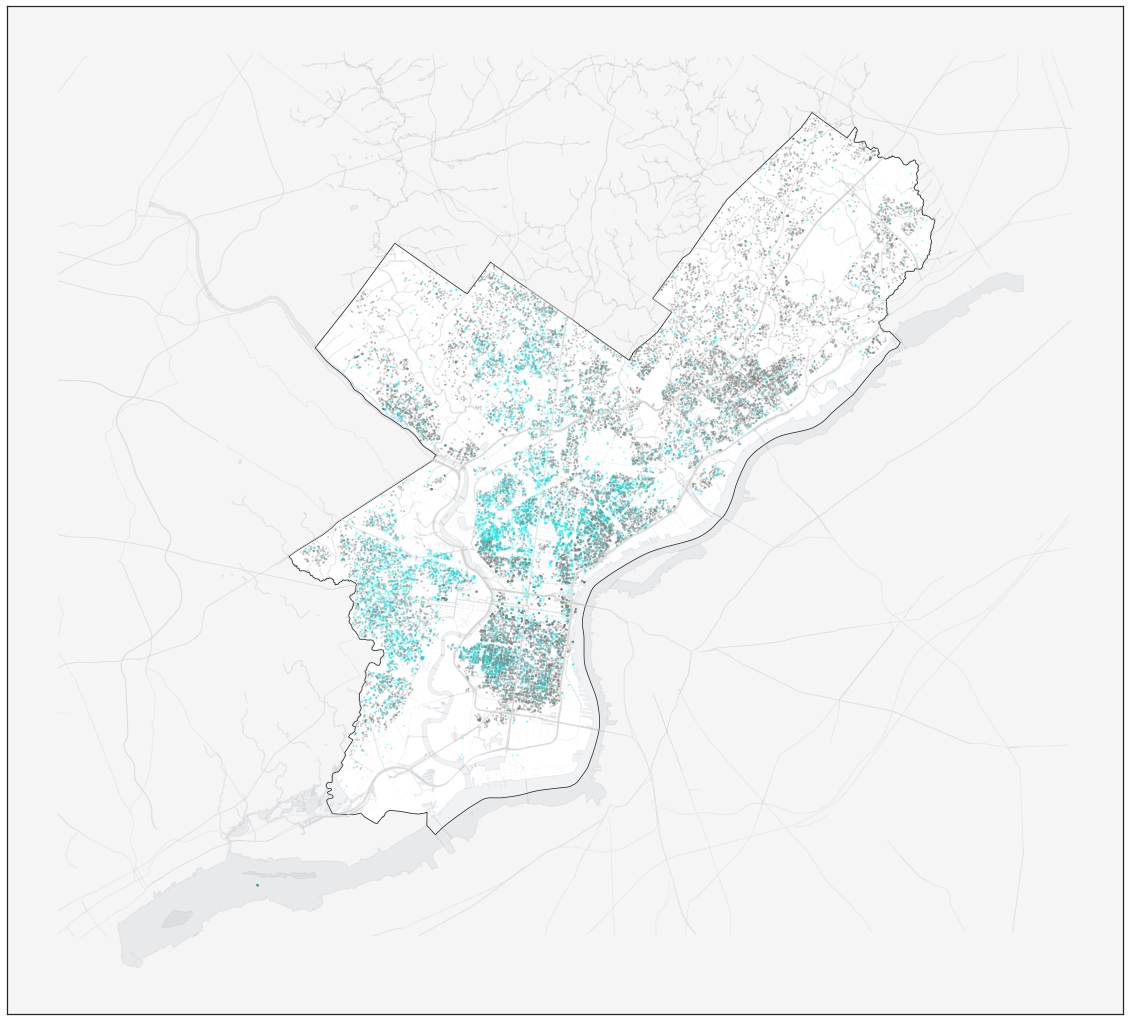

In [367]:
# 2018
fig, ax = plt.subplots(figsize=(20,20))
ax.set_aspect('equal')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

# basemap
ax.set_facecolor("whitesmoke")
city.plot(ax=ax, color="white", edgecolor="k", linewidth=.75)
water.plot(ax=ax, color="lightslategray", edgecolor="lightslategray", alpha=.1)
paroads.plot(ax=ax, color="lightgrey", linewidth=.5, alpha=0.3)
njroads.plot(ax=ax, color="lightgrey",  linewidth=.5,  alpha=0.3)
roads_minorformap.plot(ax=ax, color="lightgrey", linewidth =0.25, alpha=0.3)
roads_formap.plot(ax=ax, color="lightgrey", alpha=.3)

# 2018
deeds18.plot(ax=ax, markersize=1, column = 'grantees_y', cmap=true_false, alpha=.3)

plt.savefig("/Users/darebrawley/Google Drive/CourseWork/2019-2020/00_thesis/01_analysis/02_outputs/2018_deeds.png") 
plt.show()

## 3. selecting out high price properties
just looking at things below 20 million 

12/7/19 
didn't actually finish this......

In [332]:
likely_residential = deeds_inv_class_grantee.loc[deeds_inv_class_grantee["fair_market_value"]<20000000]

In [333]:
likely_residential18 = likely_residential.loc[likely_residential["sort_year"]==2018]

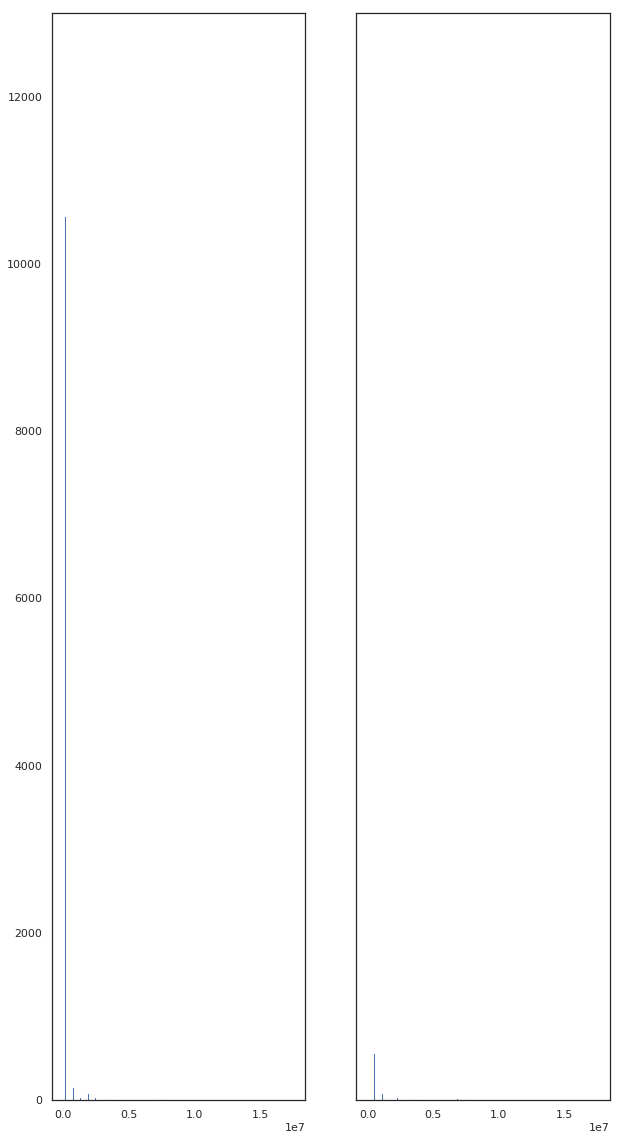

In [336]:
# price by year histogram
n_bins = 200

fig, axs = plt.subplots(1,2,figsize=(10,20),sharey=True, sharex=True)
axs[0].hist(likely_residential18["fair_market_value"], bins = n_bins)
axs[1].hist(likely_residential18["fair_market_value"], bins = n_bins)

plt.show()

In [318]:
deeds00.sort_values(by="adjusted_state_tax_amount")

adjusted_state_tax_amount  objectid document_type display_date  \
515435                        0.01   8258422          DEED   2000-09-07   
3642707                       1.00  11386429          DEED   2000-10-05   
3163924                       1.00  10793289          DEED   2000-02-18   
185474                        1.00   7928714          DEED   2000-06-15   
3296839                       1.00  11036798          DEED   2000-03-29   
1622618                       1.00   9372454          DEED   2000-12-21   
1820036                       1.00   9560727          DEED   2000-01-14   
424186                        1.00   8163082          DEED   2000-08-07   
1022043                       1.00   8775303          DEED   2000-08-28   
2946086                       1.10  10688335          DEED   2000-11-17   
3273452                       1.18  10988806          DEED   2000-03-10   
3050513                       1.23  10903525          DEED   2000-02-18   
2946315                       1.23  10688346          DEED   2000-09-15   
1676452                       1.50   9421425          DEED   2000-11-17   
955458                        2.00   8685146          DEED   2000-10-25   
444941                        2.00   8180820          DEED   2000-05-09   
956689                        2.00   8685235          DEED   2000-10-25   
420826                        2.00   8170173          DEED   2000-08-07   
3638668                       2.34  11396852          DEED   2000-05-23   
3274393                       2.36  10988828          DEED   2000-02-18   
3184895                       2.40  10961192          DEED   2000-03-03   
3586526                       2.41  11328653          DEED   2000-04-07   
29360                         2.46   7771466          DEED   2000-05-17   
252595                        2.50   8006597          DEED   2000-07-21   
3151211                       2.50  10788713          DEED   2000-02-09   
3094932                       2.50  10871668          DEED   2000-02-25   
252836                        2.50   8006608          DEED   2000-07-21   
3100527                       2.50  10871657          DEED   2000-02-25   
3152144                       2.50  10788724          DEED   2000-02-09   
3166055                       3.00  10908599          DEED   2000-03-07   
...                            ...       ...           ...          ...   
1115520                   53750.00   8869346          DEED   2000-12-13   
1115531                   53750.00   8869357          DEED   2000-12-13   
145620                    54121.48   7881022          DEED   2000-06-27   
421700                    68000.00   8162427          DEED   2000-08-22   
3607990                   71000.00  11315194          DEED   2000-05-01   
3318656                   71370.00  11059436          DEED   2000-03-24   
3659359                   75000.00  11375381          DEED   2000-05-17   
3432063                   77750.00  11159730          DEED   2000-04-13   
3658401                   80000.00  11375370          DEED   2000-05-17   
845700                    80000.00   8588930          DEED   2000-10-31   
3041751                   97000.00  10889657          DEED   2000-02-22   
1136817                  101500.00   8889594          DEED   2000-12-13   
1128376                  115297.41   8855497          DEED   2000-12-15   
3622476                  132000.00  11366163          DEED   2000-05-18   
3646606                  132182.75  11372038          DEED   2000-04-20   
3691643                  142500.00  11442504          DEED   2000-05-19   
1071965                  152500.00   8802001          DEED   2000-12-07   
1071723                  152500.00   8801990          DEED   2000-12-07   
628916                   153000.00   8369949          DEED   2000-09-21   
466385                   159250.00   8218479          DEED   2000-08-16   
79712                    170000.00   7821577          DEED   2000-06-14   
706669                   174225.37

## 3. for proposal: mapping 2018 grantees

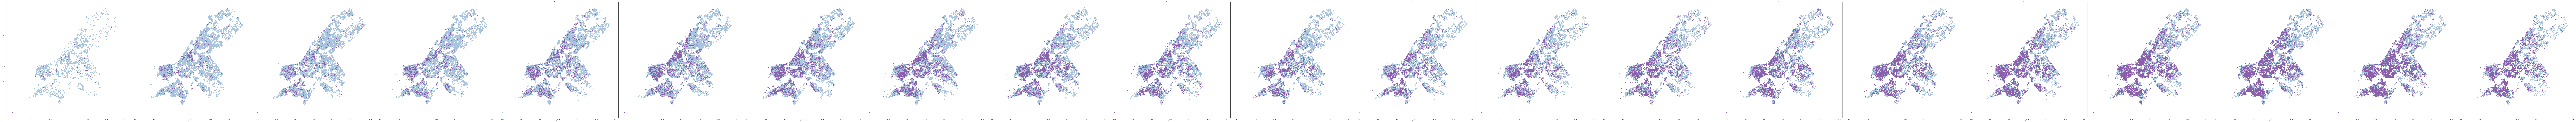

In [198]:
inve = sns.FacetGrid(deeds_inv_class_grantee, col="sort_year", 
                     hue="grantees_y",palette="BuPu", height=20)
inve.map(plt.scatter,"lat","lng")

In [75]:
deeds1718 = deeds_inv_class_grantee.loc[(deeds_inv_class_grantee["sort_year"] == '2018')|(deeds_inv_class_grantee["sort_year"] == '2017')]

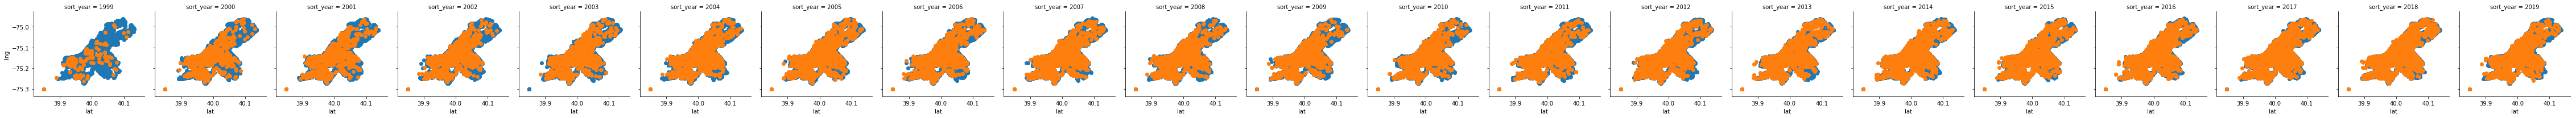

In [104]:
# fig, ax = plt.subplots()
# ax.set_aspect('equal')

inve = sns.FacetGrid(deeds_inv_class_grantee, col="sort_year", hue="grantees_y")
inve.map(plt.scatter,"lat","lng")


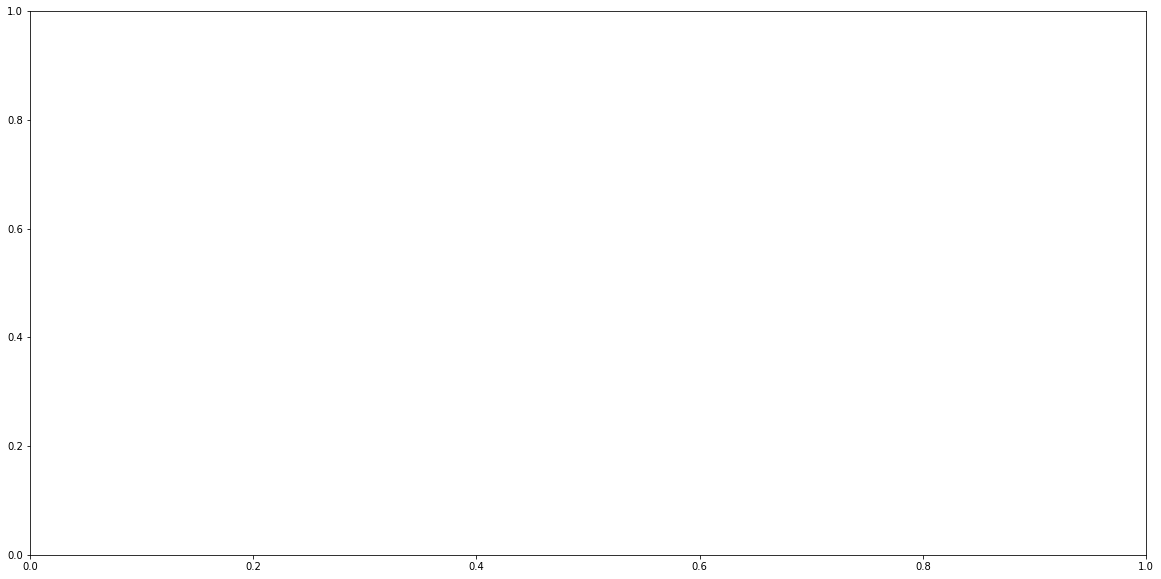

In [93]:
# plotting #deeds/year

fig, ax = plt.subplots(figsize=(20,10))
# ax.set_aspect('equal')

grouped_year = deeds_inv_class_grantee.groupby(['sort_year','grantees_y']).count()


In [94]:
grouped_year

adjusted_state_tax_amount  objectid  document_type  \
sort_year grantees_y                                                       
1920      False                               9         9              9   
          True                                1         1              1   
1922      False                               3         3              3   
          True                                1         1              1   
1923      False                               4         4              4   
1924      False                               2         2              2   
          True                               24        24             24   
1927      False                               1         1              1   
1928      True                                1         1              1   
1930      False                               5         5              5   
1931      False                               2         2              2   
1932      False                               2         2              2   
          True                                2         2              2   
1933      False                               3         3              3   
1934      False                               1         1              1   
1941      False                               1         1              1   
1942      False                               3         3              3   
1952      False                               1         1              1   
1956      False                               1         1              1   
1961      False                               3         3              3   
1962      False                               1         1              1   
1963      False                               1         1              1   
1965      False                               1         1              1   
1967      False                               3         3              3   
1969      False                              77        77             77   
          True                               24        24             24   
1970      False                              41        41             41   
          True                               13        13             13   
1971      False                               4         4              4   
          True                                2         2              2   
...                                         ...       ...            ...   
2005      False                           37902     37902          37902   
          True                             4667      4667           4667   
2006      False                           35193     35193          35193   
          True                             4400      4400           4400   
2007      False                           29081     29081          29081   
          True                             4592      4592           4592   
2008      False                           21314     21314          21314   
          True                             3634      3634           3634   
2009      False                           18260     18260          18260   
          True                             2975      2975           2975   
2010      False                           17841     17841          17841   
          True                             3626      3626           3626   
2011      False                           15813     15813          15813   
          True                             3695      3695           3695   
2012      False                           16839     16839          16839   
          True                             4612      4612           4612   
2013      False                           18686     18686          18686   
          True                             5382      5382           5382   
2014      False                           18510     18510          18510   
          True                             5572      5572           55

In [96]:
deeds_inv_class_grantee.sort_values(by='sort_year')

adjusted_state_tax_amount  objectid document_type display_date  \
3281342                     840.00  10992440          DEED   1920-10-17   
3409804                     740.00  11149239          DEED   1920-05-02   
3031417                     599.00  10772555          DEED   1920-01-20   
3184873                     231.72  10960934          DEED   1920-09-10   
3289846                      80.00  11030928          DEED   1920-12-20   
3313447                    2092.64  11053663          DEED   1920-12-20   
3289961                     293.99  11030703          DEED   1920-12-30   
3272559                    6500.00  10989032          DEED   1920-10-17   
3272560                    6500.00  10989033          DEED   1920-10-17   
3313448                    2092.64  11053664          DEED   1920-12-20   
3173187                      90.00  10961989          DEED   1922-08-02   
3105563                     120.00  10835773          DEED   1922-02-19   
3233816                     200.00  10974959          DEED   1922-08-15   
3190539                     183.74  10926919          DEED   1922-05-28   
1784105                     475.00   9524620          DEED   1923-02-03   
3022184                    1389.00  10764731          DEED   1923-01-03   
3378165                     256.22  11119629          DEED   1923-04-23   
3241627                    2000.00  11016879          DEED   1923-11-15   
3028221                     437.50  10770418          DEED   1924-11-14   
3029817                     437.50  10770413          DEED   1924-11-14   
3029815                     437.50  10770411          DEED   1924-11-14   
3029814                     437.50  10770410          DEED   1924-11-14   
3029813                     437.50  10770409          DEED   1924-11-14   
3029812                     437.50  10770408          DEED   1924-11-14   
3029811                     437.50  10770407          DEED   1924-11-14   
1205442                     650.00   8932911          DEED   1924-12-14   
3029810                     437.50  10770406          DEED   1924-11-14   
3029809                     437.50  10770405          DEED   1924-11-14   
3029808                     437.50  10770404          DEED   1924-11-14   
3029807                     437.50  10770403          DEED   1924-11-14   
...                            ...       ...           ...          ...   
3790546                      55.17  11647526          DEED   2019-01-29   
3790557                    1520.00  11647537          DEED   2019-03-29   
3790564                    1485.00  11639688          DEED   2019-03-18   
3790567                    1150.00  11639691          DEED   2019-03-15   
3790575                    1520.00  11639699          DEED   2019-02-18   
3790578                    1685.00  11639908          DEED   2019-03-12   
3790580                    2525.00  11639910          DEED   2019-01-31   
3790582                    1299.00  11639912          DEED   2019-03-18   
3790587                    1250.00  11639917          DEED   2019-02-16   
3790589                     950.00  11639919          DEED   2019-03-08   
3790611                    2940.00  11640364          DEED   2019-03-18   
3790617                    4325.00  11640370          DEED   2019-02-11   
3790815                    1850.00  11647980          DEED   2019-04-05   
3790619                    2800.00  11640582          DEED   2019-03-19   
3790624                    2200.00  11640587          DEED   2019-03-20   
3790627                     295.00  11640590          DEED   2019-03-19   
3790629                     955.14  11640591          DEED   2019-03-20   
3790631                    3850.00  11640593          DEED   2019-03-08   
3790633                      42.00  11640595          DEED   2019-03-20   
3790636                    2000.00  11640810          DEED   2019-03-22   
3790642                    4110.00  11640816          DEED   2019-02-25   
3790649                    3950.00

AttributeError: 'str' object has no attribute 'to_numeric'